### Imports

In [1]:
import numpy as _np
import matplotlib.pyplot as _plt
import pandas as _pd
import pymad8 as _m8
import sys
import os

# Add the parent folder to sys.path
parent_folder = os.path.abspath('..')
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

# Import the module from the parent folder
import XFEL_BPM

### Date and prefix

In [2]:
date = "2025_01_22"
save_name_prefix = "plots/XFEL/Dirk/" + date + "_XFEL_plot"

# Functions

In [36]:
def getFileInLinesList(inputfilename):
    file = open(inputfilename, "r")
    lines = [line.rstrip() for line in file]
    file.close()
    return lines

def checkHeader(xlines, ylines, clines):
    xnbHeader = int(xlines[0].split(' ')[1])
    ynbHeader = int(ylines[0].split(' ')[1])
    cnbHeader = int(clines[0].split(' ')[1])
    if xnbHeader == ynbHeader == cnbHeader:
        if xlines[:xnbHeader] == ylines[:xnbHeader] == clines[:xnbHeader]:
            return xnbHeader, xlines, ylines, clines
        else:
            raise ValueError("Header content not matching")
    else:
        raise ValueError("Header lenght not matching: {} | {} | {}".format(xnbHeader, ynbHeader, cnbHeader))

def getDataInDF(xfile, yfile, cfile):
    xlines = getFileInLinesList(xfile)
    ylines = getFileInLinesList(yfile)
    clines = getFileInLinesList(cfile)
    
    xnbHeader = int(xlines[0].split(' ')[1])
    ynbHeader = int(ylines[0].split(' ')[1])
    cnbHeader = int(clines[0].split(' ')[1])
    
    xbpmlist = xlines[xnbHeader-3].split(' ')
    cbpmlist = clines[cnbHeader-3].split(' ')
    slist = xlines[xnbHeader-2].split(' ')
    linelist = [bpm.split('.')[-1] for bpm in xbpmlist]
    
    mask = [x in set(xbpmlist) for x in cbpmlist]
    
    nbshot = len(xlines[xnbHeader:])
    nbbpm = len(xbpmlist)
    
    data_dict = {'Line': [], 'S': [], 'X': [], 'Y': [], 'Charge': []}
    data_dict['X'] = _np.array([xline.split(' ') for xline in xlines[xnbHeader:]], dtype=float)*1e-3
    data_dict['Y'] = _np.array([yline.split(' ') for yline in ylines[ynbHeader:]], dtype=float)*1e-3
    data_dict['Charge'] = _np.array([_np.array(cline.split(' '))[mask] for cline in clines[cnbHeader:]], dtype=float)
    
    for xline, yline, cline in zip(xlines[xnbHeader:], ylines[ynbHeader:], clines[cnbHeader:]):
        data_dict['Line'].append(linelist)
        data_dict['S'].append(_np.array(slist, dtype=float))
    for key in data_dict:
        data_dict[key] = _np.asarray(data_dict[key]).transpose().flatten()
    df = _pd.DataFrame(data_dict, index=_pd.MultiIndex.from_product([range(s) for s in (nbbpm, nbshot)], names=['BPM', 'shotID']))
    df.index.set_levels([xbpmlist], level=[0], inplace=True)
    
    return df

In [37]:
def plotJitterAndNoise(df, twissfile, line='TL', height_ratios=None, xlim=None,figsize=[14, 12]):
    df_reduced = df[df['Line'] == line]
    if xlim:
        df_reduced = df_reduced[df_reduced.S.between(xlim[0], xlim[1])]
    S = df_reduced.S.unique()
    Jitter_X, Noise_X = XFEL_BPM.calcJitterAndNoise(df_reduced, 'X')
    Jitter_Y, Noise_Y = XFEL_BPM.calcJitterAndNoise(df_reduced, 'Y')

    twiss = _m8.Output(twissfile)
    df_cut = twiss.data[twiss.data.S.between(min(S), max(S))]
    
    rows_colums = [2, 1]
    fig, ax = XFEL_BPM.plotOptions(figsize=figsize, rows_colums=rows_colums, sharex='all', height_ratios=height_ratios)
    
    _plt.subplot(rows_colums[0], rows_colums[1], 1)
    XFEL_BPM.plot2CurvesSameAxis(S, Jitter_X, Jitter_Y, ls1='+-', ls2='+-', 
                                 legend1=r'$\sigma_{J,X}$', legend2=r'$\sigma_{J,Y}$', labelX='$S$ [m]', labelY='Jitter [m]')
    
    _plt.subplot(rows_colums[0], rows_colums[1], 2)
    XFEL_BPM.plot2CurvesSameAxis(S, Noise_X, Noise_Y, ls1='+-', ls2='+-', 
                                  legend1=r'$\sigma_{N,X}$', legend2=r'$\sigma_{N,X}$', labelX='$S$ [m]', labelY='Noise [m]')
    
    fig.align_labels()
    _m8.Plot.AddMachineLatticeToFigure(fig, twiss)
    _plt.xlim(min([min(S), min(df_cut.S)]) - 2, max([max(S), max(df_cut.S)]) + 2)
    if xlim:
        _plt.xlim(xlim[0], xlim[1])

# Files

In [38]:
twissfile = '../../01_mad8/XFEL_Lattice_9/TWISS_T4D'

In [39]:
xfile = '../XFEL_data/BPM_data_Dirk/data/20240131081118XFEL1_x.txt'
yfile = '../XFEL_data/BPM_data_Dirk/data/20240131081118XFEL1_y.txt'
cfile = '../XFEL_data/BPM_data_Dirk/data/20240131081118XFEL1_charge.txt'

# Reconstuct with SVD

In [40]:
df = getDataInDF(xfile, yfile, cfile)

In [41]:
df

Line         S         X         Y    Charge
BPM           shotID                                             
BPMG.24.I1    0        I1    24.250 -0.000010  0.000274  0.236905
              1        I1    24.250 -0.000009  0.000281  0.239388
              2        I1    24.250 -0.000008  0.000282  0.240165
              3        I1    24.250 -0.000005  0.000279  0.237012
              4        I1    24.250 -0.000005  0.000278  0.236176
...                   ...       ...       ...       ...       ...
BPMW.3102.T4D 995     T4D  3102.202 -0.032846 -0.007720  0.234650
              996     T4D  3102.202 -0.030306  0.001768  0.237868
              997     T4D  3102.202 -0.024606  0.011976  0.232121
              998     T4D  3102.202 -0.015825  0.023129  0.231771
              999     T4D  3102.202 -0.007879  0.030061  0.236347

[329000 rows x 5 columns]

Mad8.readTwissFile > nrec=8541


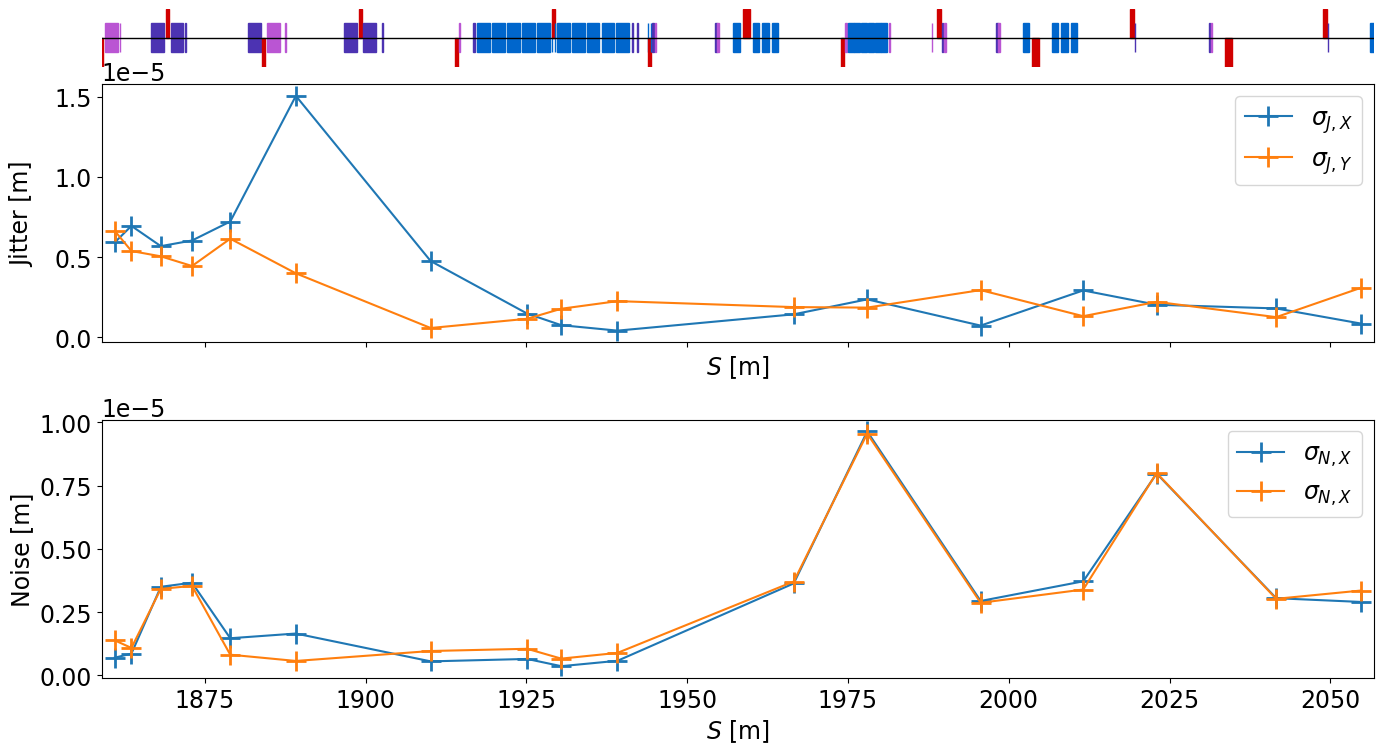

In [42]:
plotJitterAndNoise(df, twissfile, line='TL', figsize=[14, 8])

# Dirk's Results

In [129]:
def getResultFileInLinesList(inputfilename):
    file = open(inputfilename, "r")
    lines = [line.rstrip() for line in file]
    file.close()
    return lines

def getResultInDF(xfile, yfile):
    xlines = getResultFileInLinesList(xfile)
    ylines = getResultFileInLinesList(yfile)
    #clines = getResultFileInLinesList(cfile)
    
    xnbHeader = int(xlines[0].split(' ')[1])
    ynbHeader = int(ylines[0].split(' ')[1])
    #cnbHeader = int(clines[0].split(' ')[1])
    
    #xbpmlist = xlines[xnbHeader-3].split(' ')
    #cbpmlist = clines[cnbHeader-3].split(' ')
    #slist = xlines[xnbHeader-2].split(' ')
    #linelist = [bpm.split('.')[-1] for bpm in xbpmlist]
    
    #mask = [x in set(xbpmlist) for x in cbpmlist]
    
    #nbshot = len(xlines[xnbHeader:])
    #nbbpm = len(xbpmlist)
    
    bpm_list = []
    data_dict = {'S': [], 'RMSX': [], 'SigmaResX': [], 'SigmaResErrorX': [], 'RMSY': [], 'SigmaResY': [], 'SigmaResErrorY': []}
    
    #for xline, yline, cline in zip(xlines[xnbHeader:], ylines[ynbHeader:], clines[cnbHeader:]):
    for xline, yline in zip(xlines[xnbHeader+1:], ylines[ynbHeader+1:]):
        bpm_list.append(xline.split(' ')[0])
        data_dict['S'].append(float(xline.split(' ')[1]))
        data_dict['RMSX'].append(float(xline.split(' ')[3])*1e-3)
        data_dict['SigmaResX'].append(float(xline.split(' ')[9])*1e-3)
        data_dict['SigmaResErrorX'].append(float(xline.split(' ')[10])*1e-3)
        data_dict['RMSY'].append(float(yline.split(' ')[3])*1e-3)
        data_dict['SigmaResY'].append(float(yline.split(' ')[9])*1e-3)
        data_dict['SigmaResErrorY'].append(float(yline.split(' ')[10])*1e-3)
    for key in data_dict:
        data_dict[key] = _np.asarray(data_dict[key]).transpose().flatten()
    df = _pd.DataFrame(data_dict, index=bpm_list)
    
    return df

In [163]:
def plotResolution(resultfilex, resultfiley, twissfile, figsize=[14, 4]):
    df = getResultInDF(resultfilex, resultfiley)
    
    df_reduced = df[df.S.between(1850, 2200)]

    fig, ax = fig, ax = XFEL_BPM.plotOptions(figsize=figsize, rows_colums=[1, 1], sharex='all', height_ratios=[1])
    S = df_reduced.S.values
    
    #_plt.subplot(2, 1, 1)
    #_plt.plot(S, df_reduced.RMSX.values, '+-', markersize=15, label="X")
    #_plt.plot(S, df_reduced.RMSY.values, '+-', markersize=15, label="Y")
    #_plt.ylabel("Jitter [m]")
    #_plt.legend()
    
    #_plt.subplot(2, 1, 2)
    _plt.plot(S, df_reduced.SigmaResX.values, '+-', markersize=15, label="X")
    _plt.plot(S, df_reduced.SigmaResY.values, '+-', markersize=15, label="Y")
    _plt.ylabel("Noise [m]")
    _plt.xlabel("S [m]")
    _plt.legend()

    twiss = _m8.Output(twissfile)
    df_cut = twiss.data[twiss.data.S.between(min(S), max(S))]
    _m8.Plot.AddMachineLatticeToFigure(fig, twiss)
    _plt.xlim(min([min(S), min(df_cut.S)]) - 2, max([max(S), max(df_cut.S)]) + 2)

In [164]:
file1x = "../XFEL_data/BPM_data_Dirk/data/20240131081118XFEL1_x.results"
file1y = "../XFEL_data/BPM_data_Dirk/data/20240131081118XFEL1_y.results"
file2 = "../XFEL_data/BPM_data_Dirk/data/20240131081635XFEL2_x.results"

twissfileT1 = '../../01_mad8/XFEL_Lattice_9/TWISS_T5D'
twissfileT2 = '../../01_mad8/XFEL_Lattice_9/TWISS_T4D'

Mad8.readTwissFile > nrec=8411


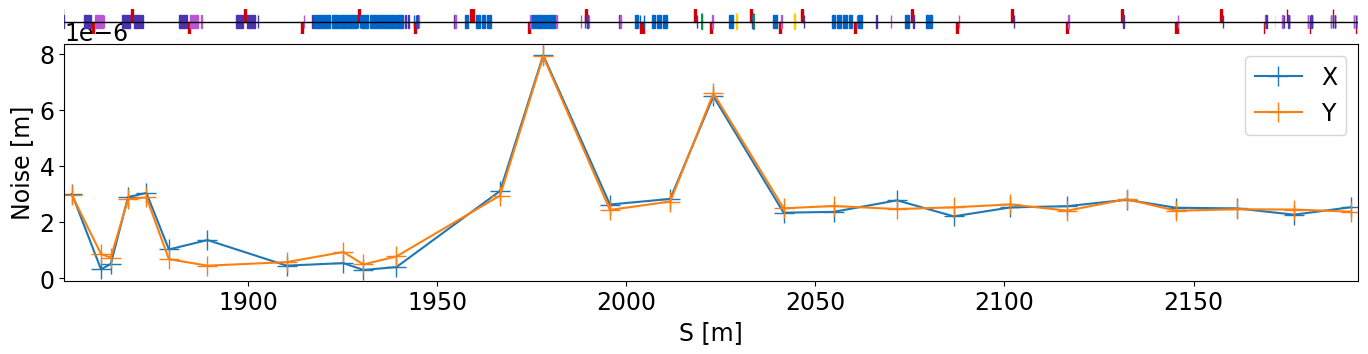

In [165]:
plotResolution(file1x, file1y, twissfileT1)